# ADAML workshop 3: Recurrent Neural Network

LUT University \
BM20A6100 Advanced Data Analysis and Machine Learning \
Week 10 - Workshop 3 - Recurrent Neural Network

Elias Eskelinen \
elias.eskelinen@student.lut.fi

___

## Model implementation

RNN model implementation, as instructed in class.

(1200, 20, 1) (1200, 1)

Test MSE: 0.014267



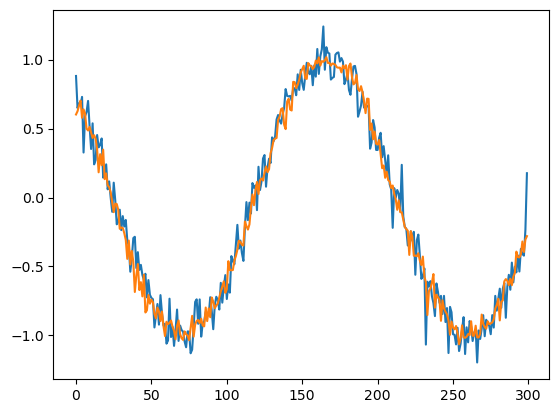

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
np.random.seed(42)

class RNN:
    def __init__(self, input_size, hidden_size, output_size, lr=1e-3, seed=1):
        rng = np.random.RandomState(seed)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        self.lr = lr
        self.Wxh = rng.randn(hidden_size, input_size)
        self.Whh = rng.randn(hidden_size, hidden_size)
        self.Why = rng.randn(output_size, hidden_size)
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    # In forward model we feed the data X through the network
    def forward(self, X: np.ndarray): 
        #assert X.ndim == 3, "X must be a 3D matrix"
        
        # Determine batch size and sequence length
        batch, seq_len, _ = X.shape

        # Initialize hidden state
        h = np.zeros((batch, seq_len+1, self.hidden_size))

        # Propagate the input trough hidden layers
        for t in range(seq_len): 

            # Reshape the input
            xt = X[:, t, :].reshape(batch, 1)

            # Compute the hidden layer output.T
            pre = xt.dot(self.Wxh.T) + h[:, t, :].dot(self.Whh.T) + self.bh.T
            h[:, t+1, :] = np.tanh(pre) # Apply activation function to hidden state (here, tanh is used)

            # Compute the output 
            y_pred = h[:, -1, :].dot(self.Why.T) + self.by

        # Return hidden state and predicted output
        return h, y_pred

    # Compute the Mean Square Error loss
    def loss(self, y_pred: np.ndarray, y_true: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        diff = y_true - y_pred
        return np.mean(diff**2), diff

    # Backpropagation
    def bptt_update(self, X, h, y_pred, y_true):
        # Using backpropagation through time (bptt) to update the weights
        # X: (batch, seq_len, input_size)

        batch_size, seq_len, _ = X.shape

        # Init the gradients
        dWxh, dWhh, dWhy= np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)

        # Compute the gradient of the output wrt. loss
        dy = (y_pred - y_true) * (2.0 / batch_size)

        h_lash = h[:, -1, :].reshape(batch_size, self.hidden_size)

        # Compute the gradients of the loss wrt. output layer weights and biases
        dWhy += dy.T.dot(h_lash)
        dby += dy.T.sum(axis=1, keepdims=True)

        # Compute the gradient of the loss wrt the hidden state
        dh_next = dy.dot(self.Why)

        for t in reversed(range(seq_len)): 
            ht = h[:, t+1, :]
            ht_prev = h[:, t, : ]

            # Gradient of the activation function (tanh) and hidden biases
            dt = dh_next*(1 - ht**2)
            dbh = dt.T.sum(axis=1, keepdims=True)

            # Get inputs at t
            xt = X[:, t, :].reshape(batch_size, -1)

            # Comute the gradients of the hidden weights and hidden state
            dWxh += dt.T.dot(xt)
            dWhh += dt.T.dot(ht_prev)

            # Compute the gradient that is propagated to the next time step 
            dh_next = dt.dot(self.Whh)

        # Clip the gradients for numerical stability
        for grad in (dWhh, dWxh, dWhy, dbh, dby): 
            np.clip(grad, -5, 5, out=grad)

        # Update the parameters
        self.Wxh -= self.lr * dWxh
        self.Whh -= self.lr * dWhh
        self.Why -= self.lr * dWhy
        self.bh -= self.lr * dbh
        self.by -= self.lr * dby
        return 

    def train(self, X, y, epochs=50, batch_size=32, verbose=True):
        #assert X.ndim == 3 and len(y) == y.size, 'X must be a 3D matrix and y must be a vector'
        assert len(X) == len(y), 'X and y must be the same length'
        
        # Length of X
        n = X.shape[0]
        losses=[]

        # Training loop
        for epoch in range(1, epochs + 1): 

            # Shuffle the indices
            idx = np.random.permutation(n)
            X_shuffled, y_shuffled = X[idx], y[idx]

            # Iterate over batches
            loss_epoch = 0.0
            for i in range(0, n, batch_size): 

                # Take one batch
                X_batch, y_batch = X_shuffled[i:i+batch_size], y_shuffled[i:i+batch_size]

                # Forward propagate the batch
                h, y_pred = self.forward(X_batch)

                # Compute model loss
                loss, _ = self.loss(y_pred, y_batch)
                loss_epoch += loss * X_batch.shape[0]

                # Compute the gradient wrt. loss and backward propagate
                self.bptt_update(X_batch, h, y_pred, y_batch)

            # Normalize the loss
            loss_epoch /= n
            losses.append(loss_epoch)

        # Return the loss history
        return losses

def generate_sine_sequences(n_samples=2000, seq_len=20, input_size=1, seed=0):
    rng = np.random.RandomState(seed)
    x = np.linspace(0, 50, n_samples * seq_len * input_size)
    data = np.sin(x) + 0.1 * rng.randn(n_samples * seq_len * input_size)
    X = data.reshape(n_samples, seq_len, input_size)
    rolled = np.roll(data, -1).reshape(n_samples, seq_len, input_size)
    y_last = rolled[:, -1, :]
    return X.astype(np.float32), y_last.astype(np.float32)

# Creating the data
X, y = generate_sine_sequences(n_samples=1500, seq_len=20, input_size=1)
# train/test split
split = int(0.8 * X.shape[0])
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

print(X_train.shape, y_train.shape)

# Training the network
rnn = RNN(input_size=1, hidden_size=80, output_size=1, lr=1e-3)
losses = rnn.train(X_train, y_train, epochs=600, batch_size=8, verbose=True)

# Test set
_, y_pred_test = rnn.forward(X_test)
test_loss, _ = rnn.loss(y_pred_test, y_test)
print(f"\nTest MSE: {test_loss:.6f}\n")

# Plotting the predictions.
plt.plot(y_test)
plt.plot(y_pred_test)
plt.savefig("rnn_pred.png")
plt.show()

___

## Data onboarding and preprocessing

Import dependencies

In [17]:
import os
import nltk
import pandas as pd
import kagglehub
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import torch 
torch.manual_seed(42)

Fetch the data from kaggle API

In [18]:
# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("tanishqdublish/text-classification-documentation")
data_path = os.path.join(data_dir, os.listdir(data_dir)[0]);

data = pd.read_csv(data_path)
print(data.shape)
print(data.head())

(2225, 2)
                                                Text  Label
0  Budget to set scene for election\n \n Gordon B...      0
1  Army chiefs in regiments decision\n \n Militar...      0
2  Howard denies split over ID cards\n \n Michael...      0
3  Observers to monitor UK election\n \n Minister...      0
4  Kilroy names election seat target\n \n Ex-chat...      0


The data consists of paragraphs of text and labels corresponding to each paragraph. We split the data to features and labels.

In [19]:
X, y = data['Text'], data['Label']

Next, we preprocess the data. We start by tokenizing each paragraph using `nltk.word_tokenize`; this splits each paragraph to a list of individual words. After that, we build a token vocabulary i.e. list all unique tokens found in the data, and encode the data to number format. Finally, we pad/truncate each sample to length `max_len`. 

In [20]:
# Download NLTK tokenizer data (only the first time)
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def pad(tokens: np.array, max_len=30, pad_val=0) -> list: 
    if len(tokens) > max_len: 
        return tokens[-max_len:]
    elif len(tokens) < max_len: 
        return np.hstack([np.full(max_len-len(tokens), pad_val), tokens])
    return tokens

# Tokenize the data
X_tokenized = [word_tokenize(text.lower()) for text in X]

# Count tokens
counter = Counter()
for tokens in X_tokenized: counter.update(tokens)

# Build vocabulary 
min_freq = 1
vocabulary = {"<PAD>": 0, "<UNK>": 1}
for token, freq in counter.items():
    if freq >= min_freq: vocabulary[token] = len(vocabulary)

# Encode tokenized data
X_encoded = [[vocabulary.get(t, vocabulary["<UNK>"]) for t in tokens] for tokens in X_tokenized]

# Pad sequences 
max_len = 50
X_padded = torch.tensor([pad(x) for x in X_encoded], dtype=torch.long)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eliaseskelinen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We convert the data to `torch.Tensor` and split the data to training and test sets.

In [21]:
X_tensor, y_tensor = torch.tensor(X_padded, dtype=torch.long), torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)

/var/folders/vf/n0vzkjgd5pq00lx832rc0pf80000gn/T/ipykernel_39954/2784726971.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor, y_tensor = torch.tensor(X_padded, dtype=torch.long), torch.tensor(y, dtype=torch.long)


___

## Classifier implementation



We implement a simple modular classifier class `RecurrentClassifier`, which can be initialized as a RNN or LSTM model using `torch.nn.Sequential`.

In [22]:
from torch.nn import Module as NNModule, RNN, LSTM, Sequential, Embedding, Linear, CrossEntropyLoss
from torch.optim import Adam
from torch import Tensor
from sklearn.metrics import accuracy_score
    
# Define a wrapper class for Sequential with the predict method
class RecurrentClassifier(NNModule): 
    def __init__(self, *layers): 
        super().__init__()
        self.model = Sequential(*layers)

    def forward(self, X: Tensor) -> Tensor: 
        return self.model(X)

    def predict(self, X: Tensor) -> Tensor: 
        return torch.argmax(self.model(X), axis=1)

Next, we initialize wrapper classes for both `torch.nn.RNN` and `torch.nn.LSTM`, so that these can be used as layers in `RecurrentClassifier`. These can be initialized by passing `input_size` and `output_size`. 

In [23]:
# Define a wrapper class for RNN so that it can be used in Sequential
class SimpleRNN(NNModule): 
    def __init__(self, input_size: int, output_size: int): 
        super().__init__()
        self.model = RNN(input_size, output_size, batch_first=True)
    
    def forward(self, X):
        _, hidden = self.model(X)
        return hidden[-1]
    
# Define a wrapper class for LSTM so that it can be used in Sequential
class SimpleLSTM(NNModule): 
    def __init__(self, input_size: int, output_size: int): 
        super().__init__()
        self.model = LSTM(input_size, output_size, batch_first=True)
    
    def forward(self, X):
        _, (hidden, _) = self.model(X)
        return hidden[-1]

Finally, we implement a training routine which can be used to train `RecurrentClassifier` models. The routine can be called by passing a `RecurrentClassifier` model and training feature set `X_train` and label set `y_train`; the routine can be customized by passing `learning_rate`, `batch_size`, `tol` (convergence check parameter), `max_iter` and `criterion_class` (loss function class). The routine returns a list `loss_history` which contains model loss evaluated over epochs. By default, `torch.CrossEntropyLoss` is used as the criterion. 

In [24]:
# Define a function to train models
def train(model: RecurrentClassifier, X_train: Tensor, y_train: Tensor, \
        learning_rate=0.001, batch_size=32, tol=0.001, max_iter=100, criterion_class=CrossEntropyLoss):
        assert len(X_train) == len(y_train), "X_train and y_train must be the same length"

        # Setup optimizer, set model to training mode and initialize criterion
        optimizer = Adam(model.parameters(), lr=learning_rate)
        model.train()
        criterion = criterion_class()

        # Training loop
        loss_history = []
        for epoch in range(max_iter):
            
            # Shuffle input data
            indices = torch.randperm(len(X_train))
            X_shuffled, y_shuffled = X_train[indices], y_train[indices]
            
            # Optimize with batches
            epoch_loss = 0.0
            for i in range(0, len(X_train), batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward + backward
                optimizer.zero_grad()
                y_pred = model.forward(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                # Add to epoch loss
                epoch_loss += loss.item()

            # Compute average epoch loss
            avg_loss = epoch_loss / (len(X_train) // batch_size)
            loss_history.append(avg_loss)

            # Convergence check 
            if len(loss_history) > 1 and abs(loss_history[-2]- loss_history[-1]) < tol: break

        return loss_history

___

## Testing RNN classifier

We initialize a `RecurrentClassifier` model with a `RNN` layer, essentially a RNN classifier model. The model has a `torch.Embedding` layer for computing token embeddings, a `SimpleRNN` layer and a `torch.Linear` output layer. 


We train the model using `X_train` and `y_train` (see section Data onboarding and preprocessing) and test model performance by applying the model on `X_test` and computing prediction accuracy. The training loop uses the criterion `torch.nn.CrossEntropyLoss`.

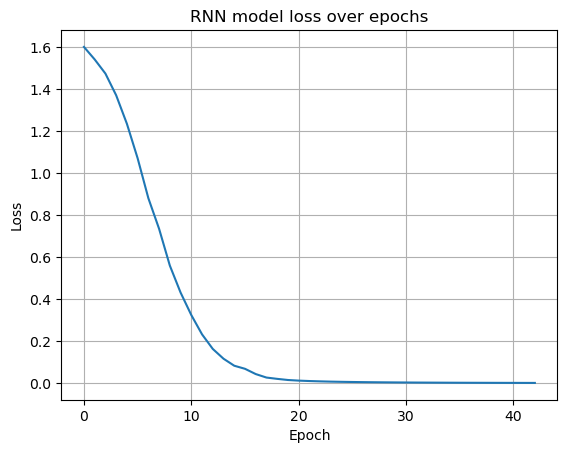

Accuracy: 43 %


In [25]:
# Define RNN model parameters
input_size = len(vocabulary)
embedding_size = 64
hidden_size = 64
output_size = len(np.unique(y))

# Initialize LSTM model
model = RecurrentClassifier(
    Embedding(input_size, embedding_size), 
    SimpleRNN(embedding_size, hidden_size),
    Linear(hidden_size, output_size)
)

# Train LSTM model 
losses = train(model, X_train, y_train,
    learning_rate=0.001, 
    batch_size=32, 
    tol=0.0001, max_iter=100
)

# Visualize model loss over epochs
plt.plot(losses)
plt.title("RNN model loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Predict the test set and compute prediction accuracy
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.0f} %")

The RNN model achieved 43 % accuracy. 

___

## Testing LSTM classifier

We initialize a `RecurrentClassifier` model with a `LSTM` layer, essentially a LSTM classifier model. The model has a `torch.Embedding` layer for computing token embeddings, a `SimpleLSTM` layer and a `torch.Linear` output layer. 

We train the model using `X_train` and `y_train` (see section Data onboarding and preprocessing) and test model performance by applying the model on `X_test` and computing prediction accuracy. The training loop uses the criterion `torch.nn.CrossEntropyLoss`.

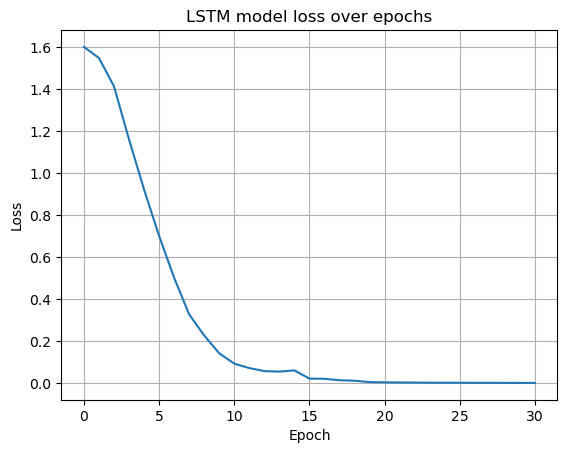

Accuracy: 56 %


In [26]:
# Define LSTM model parameters
input_size = len(vocabulary)
embedding_size = 64
hidden_size = 64
output_size = len(np.unique(y))

# Initialize LSTM model
model = RecurrentClassifier(
    Embedding(input_size, embedding_size), 
    SimpleLSTM(embedding_size, hidden_size),
    Linear(hidden_size, output_size)
)

# Train LSTM model 
losses = train(model, X_train, y_train,
    learning_rate=0.001, 
    batch_size=32, 
    tol=0.0001, max_iter=100
)

# Visualize model loss over epochs
plt.plot(losses)
plt.title("LSTM model loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Predict the test set and compute prediction accuracy
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.0f} %")

The RNN model achieved 57 % accuracy. 

___

## Conclusions

We implemented a RNN regression model, which achieved a MSE score of 0.014267. We also implemented RNN and LSTM classifier models for classifying a natural language dataset. These models were trained on a training subset of the data achieved accuracies of 44 % and 57 %, respectively, on a testing subset. Improvements in accuracy could be achieved by tuning the model hyperparameters, improving data preprocessing and testing different model configurations. 

___

## Sources

Dev. Learn How to Build Multi-Class Text Classification Models with RNN and LSTM. Available: https://dev.to/aionlinecourse/learn-how-to-build-multi-class-text-classification-models-with-rnn-and-lstm-ned 

Datacamp. Recurrent Neural Network Tutorial (RNN). Available: https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network

Pytorch. PyTorch documentation. Available: https://docs.pytorch.org/docs/stable/index.html 

GeeksForGeeks. Implementing Recurrent Neural Networks in PyTorch. Available: https://www.geeksforgeeks.org/deep-learning/implementing-recurrent-neural-networks-in-pytorch/

GeeksForGeeks. Tokenize text using NLTK in python. Available: https://www.geeksforgeeks.org/nlp/tokenize-text-using-nltk-python/

NLTK. NLTK Documentation. Available: https://www.nltk.org/howto.html

Tanishq Dublish, Kaggle. Text classification documentation. Available: https://www.kaggle.com/datasets/tanishqdublish/text-classification-documentation/data

